In [2]:
# import relevant modules
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from helper_functions.utils import *

# Define constants and helpers
IMG_DIR = "../data/train/combine"
png_files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith('.png')]

def imshow(img, title, subplot=None):
    if subplot:
        plt.subplot(subplot)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title(title)

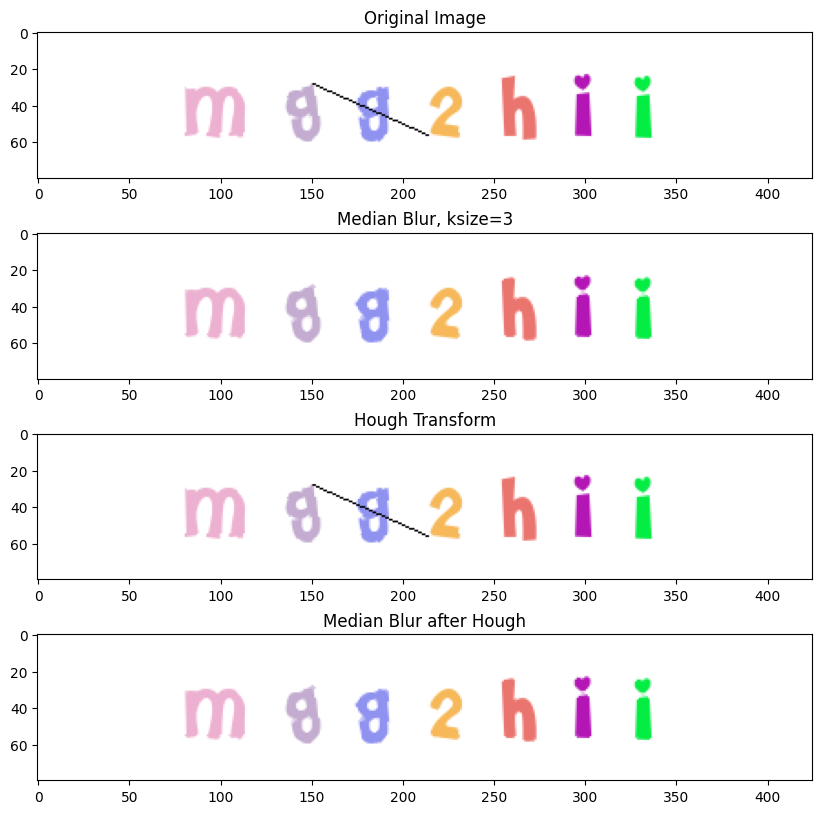

In [3]:
"""
Experiment with denoising
"""
img = cv2.imread(os.path.join(IMG_DIR, random.choice(png_files)))

"""Median blur"""
medianBlur = cv2.medianBlur(img, 3)

"""Hough transform"""
houghTransform = img.copy()
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binary = cv2.adaptiveThreshold(grayImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
edges = cv2.Canny(binary, 50, 150)
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=75, maxLineGap=10)
# Remove lines by drawing over them
mask = np.zeros_like(grayImg)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(mask, (x1, y1), (x2, y2), 255, 2)  # Draw white lines on black mask
cleaned = cv2.inpaint(img, mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
medianBlurHough = cv2.medianBlur(cleaned, 3)


plt.figure(figsize=(10, 10))
imshow(img, "Original Image", 411)
imshow(medianBlur, "Median Blur, ksize=3", 412)
imshow(cleaned, "Hough Transform", 413)
imshow(medianBlurHough, "Median Blur after Hough", 414)


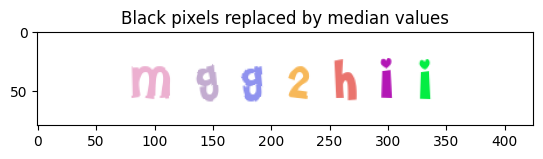

In [4]:
"""
FINAL DENOISING METHOD: replace black with median
"""

# Replace all black lines with white
def replace_black_with_median(image, kernel_size=5):
    """
    Replaces all black pixels in an image with the median of their local neighborhood.
    
    :param image: Input image (grayscale or color)
    :param kernel_size: Size of the patch used for computing the median
    :return: Image with black pixels replaced by median values
    """
    # Convert to grayscale if the image is colored
    is_color = len(image.shape) == 3
    
    # Define black pixel condition
    if is_color:
        black_pixels = np.all(image == [0, 0, 0], axis=-1)  # Mask for black pixels
    else:
        black_pixels = (image == 0)  # Grayscale mask

    # Compute median blur (preserves edges better than Gaussian blur)
    median_filtered = cv2.medianBlur(image, kernel_size)
    
    # Replace black pixels with median values
    image[black_pixels] = median_filtered[black_pixels]

    return image


# Apply function

result = replace_black_with_median(img)

imshow(result, "Black pixels replaced by median values")



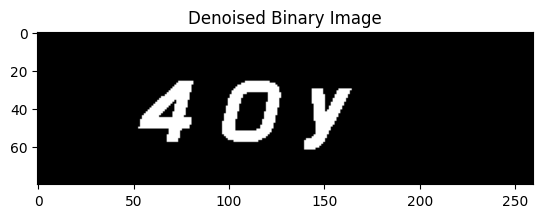

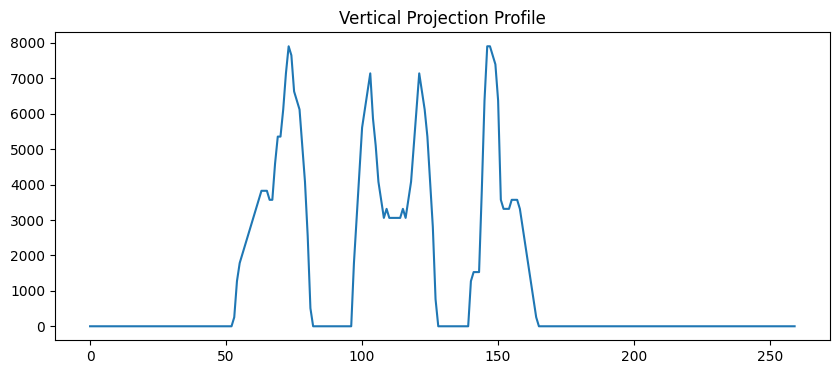

[(np.int64(52), np.int64(82)), (np.int64(96), np.int64(128)), (np.int64(139), np.int64(165))]


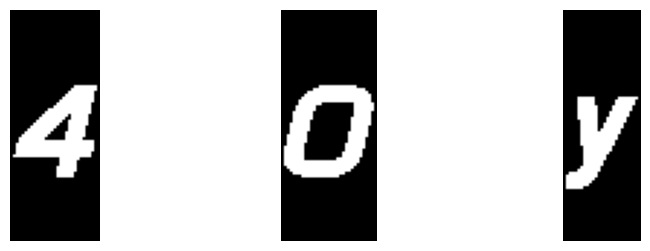

In [5]:
"""
Now try tokenisation methods
"""

# # Randomly sample 100 files (or all if fewer than 100)
# sampled_files = random.sample(png_files, min(1, len(png_files)))
# print(sampled_files)

# for i, filepath in enumerate(sampled_files):
#     img = cv2.imread(f"data/train/jh/{filepath}")
#     if img is None: continue
#     result = replace_black_with_median(img.copy())
#     imshow(img, f"Original", 211)
#     imshow(result, "Denoised image", 212)

# Apply thresholding to binarize the image
img = get_random_train_img(IMG_DIR)
cleaned = replace_black_with_median(img.copy())
cleaned_gray = cv2.cvtColor(cleaned, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(cleaned_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(binary, "Denoised Binary Image", 211)



"""
CCA
"""
# # Find connected components
# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# char_images = []
# for cnt in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     char_images.append(binary[y:y+h, x:x+w])  # Crop character

# # Sort by x-coordinates to maintain reading order
# char_images = sorted(char_images, key=lambda im: im.shape[1])

# # Display segmented characters
# for i, char in enumerate(char_images):
#     plt.subplot(21, len(char_images), i+2)
#     plt.imshow(char, cmap='gray')
#     plt.axis('off')

"""
Projection
"""
# Compute vertical projection (sum of pixel values along columns)
vertical_proj = np.sum(binary, axis=0)

# Plot the vertical projection for visualization
plt.figure(figsize=(10, 4))
plt.plot(vertical_proj)
plt.title("Vertical Projection Profile")
plt.show()

# Identify segmentation points (valleys where projection value is low)
threshold = np.max(vertical_proj) * 0.01  # Adjust threshold as needed
segmentation_points = np.where(vertical_proj < threshold)[0]

# Filter out very close points to avoid excessive splitting
filtered_points = []
prev = 0  # Ensure spacing
for point in segmentation_points:
    if point - prev > 2:  # Adjust spacing threshold
        filtered_points.append((prev, point))
    prev = point
print(filtered_points)


# Extract individual characters using bounding boxes
char_images = []
prev = 0
for prev,point in filtered_points:
    char_images.append(binary[:, prev:point+1])
    # if point - prev > 2:  # Avoid cutting too narrowly
    #     print(prev, point)
    #     char_images.append(binary[:, prev:point])
    # prev = point

if len(char_images) > 0:
    fig, axes = plt.subplots(1, len(char_images), figsize=(10, 3))
    for i, char in enumerate(char_images):
        axes[i].imshow(char, cmap='gray')
        axes[i].axis('off')
    plt.show()
else:
    print("No characters detected.")

